# **Project Objective: PJM Hourly Energy Consumption Forecasting**

The objective of this project is to analyze and forecast hourly energy consumption data for the PJM Interconnection, a regional transmission organization in the United States.

In [1]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load the dataset
df=pd.read_csv('/content/PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [3]:
#convert to datetime and set datetime as index
df['Datetime']=pd.to_datetime(df['Datetime'])
df.set_index(['Datetime'],inplace=True)  #setting date as index

In [4]:
#create time-based features
df['hour']=df.index.hour
df['day']=df.index.day
df['month']=df.index.month
df['year']=df.index.year
df['weekday']=df.index.weekday #0 indicates monday
df['is_weekday']=df['weekday']>=5

#check for structure
print(df.head())

                     PJMW_MW  hour  day  month  year  weekday  is_weekday
Datetime                                                                 
2002-12-31 01:00:00   5077.0     1   31     12  2002        1       False
2002-12-31 02:00:00   4939.0     2   31     12  2002        1       False
2002-12-31 03:00:00   4885.0     3   31     12  2002        1       False
2002-12-31 04:00:00   4857.0     4   31     12  2002        1       False
2002-12-31 05:00:00   4930.0     5   31     12  2002        1       False


In [5]:
#check for null values
df.isnull().sum()

,0
PJMW_MW,0
hour,0
day,0
month,0
year,0
weekday,0
is_weekday,0


There are no null value our dataset is cleaned.

# **Data Visualisation**

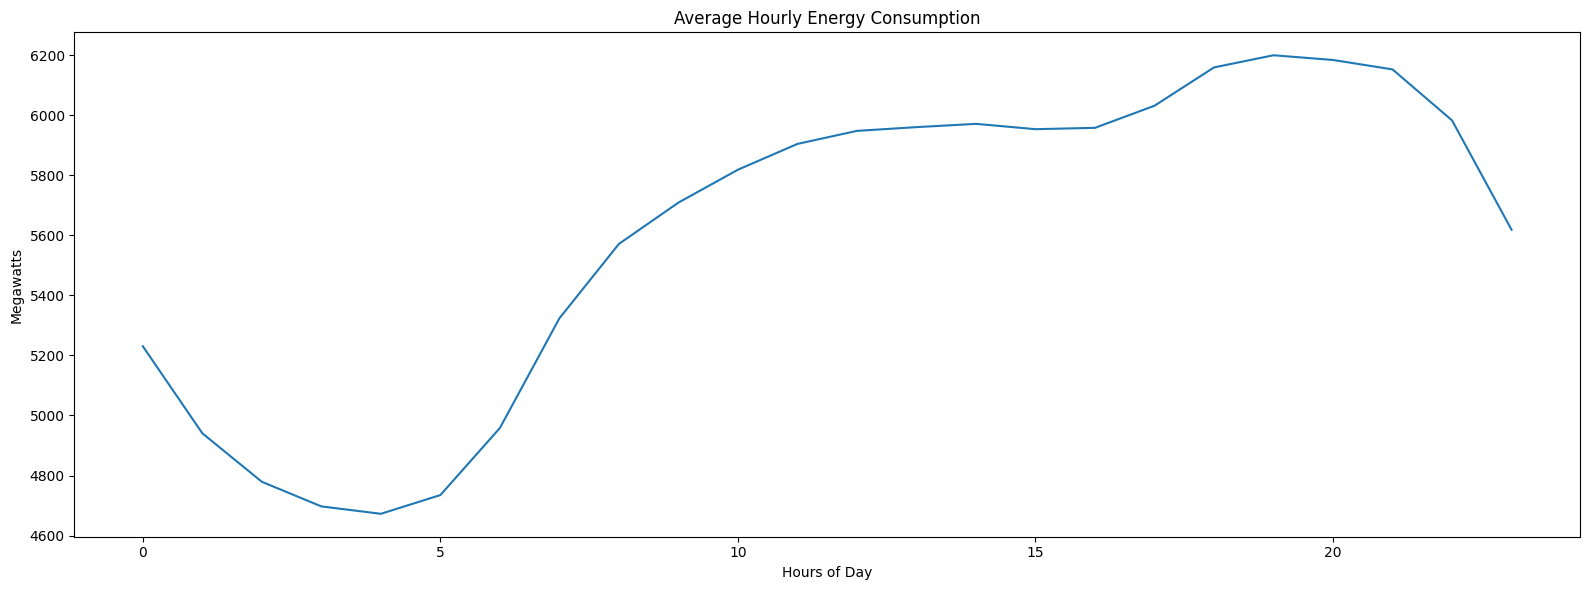

In [6]:
 #Average Hourly Consumption
plt.figure(figsize=(16,6))
sns.lineplot(x='hour',y='PJMW_MW',data=df.groupby('hour')['PJMW_MW'].mean().reset_index())
plt.title("Average Hourly Energy Consumption")
plt.xlabel("Hours of Day")
plt.ylabel('Megawatts')
plt.tight_layout()
plt.show()

This plot reflects a typical human activity cycle:

*   Low overnight,

*   Ramp-up in the morning,

*   Sustained daytime demand, and

*   Peak in the evening.





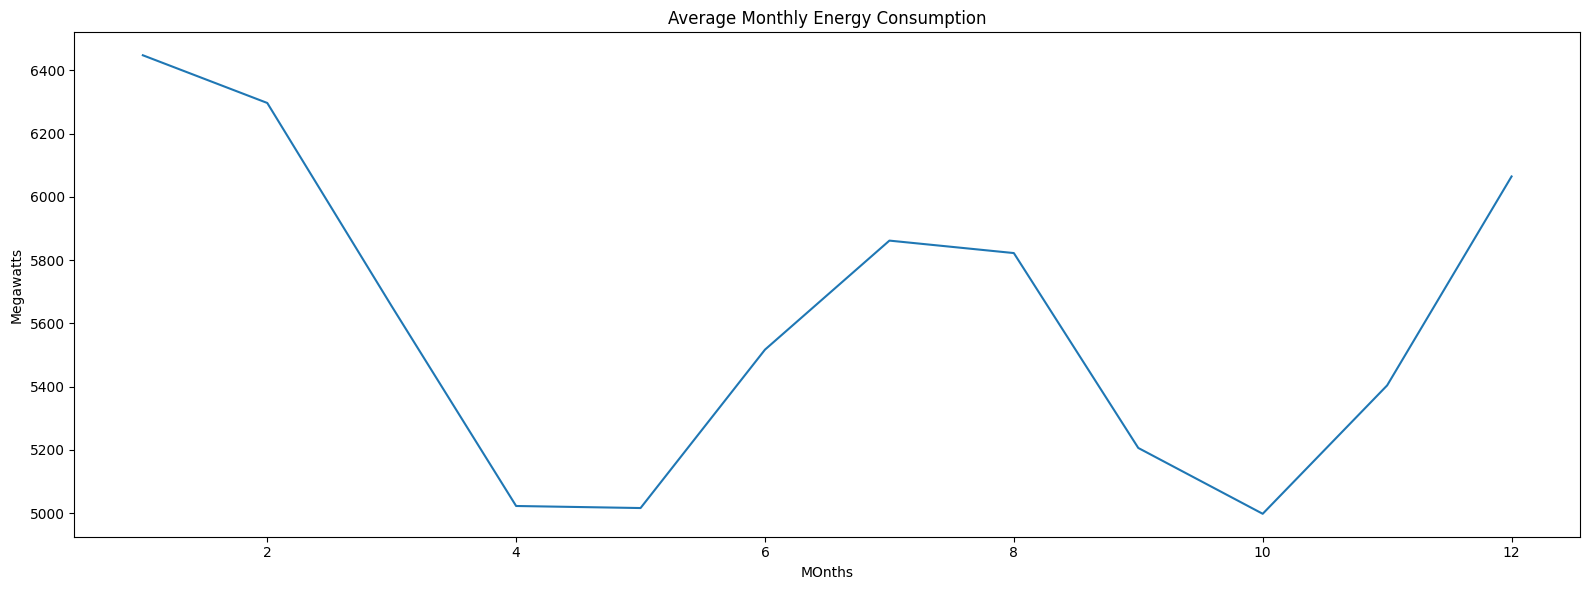

In [7]:
#Average Monthly Consumption
plt.figure(figsize=(16,6))
sns.lineplot(x='month',y='PJMW_MW',data=df.groupby('month')['PJMW_MW'].mean().reset_index())
plt.title("Average Monthly Energy Consumption")
plt.xlabel("MOnths")
plt.ylabel('Megawatts')
plt.tight_layout()
plt.show()

The plot reflects a seasonal energy consumption pattern with peaks in winter and summer, and lows in spring and early autumn.

/tmp/ipython-input-8-2095508934.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday',y='PJMW_MW',data=df.groupby('weekday')['PJMW_MW'].mean().reset_index(),palette='coolwarm')


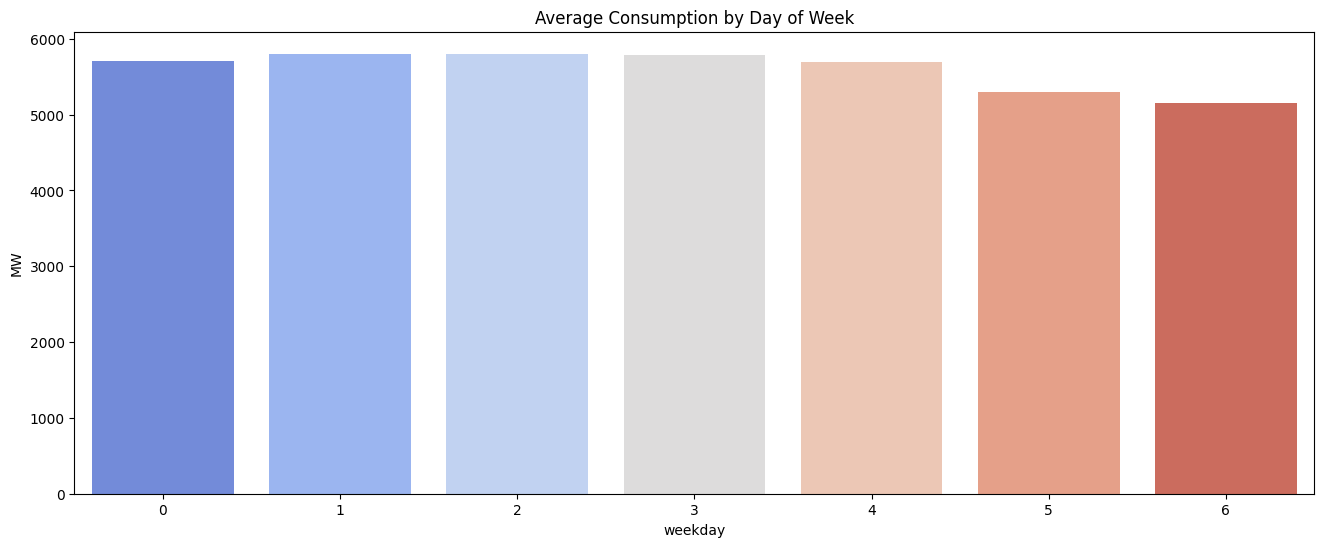

In [8]:
#Average Energy Consumption per days of week
plt.figure(figsize=(16,6))
sns.barplot(x='weekday',y='PJMW_MW',data=df.groupby('weekday')['PJMW_MW'].mean().reset_index(),palette='coolwarm')
plt.title('Average Consumption by Day of Week')
plt.ylabel('MW')
plt.show()

We can see that during weekends there is drop in average energy consumption comared to weekday , people might be taking rest .

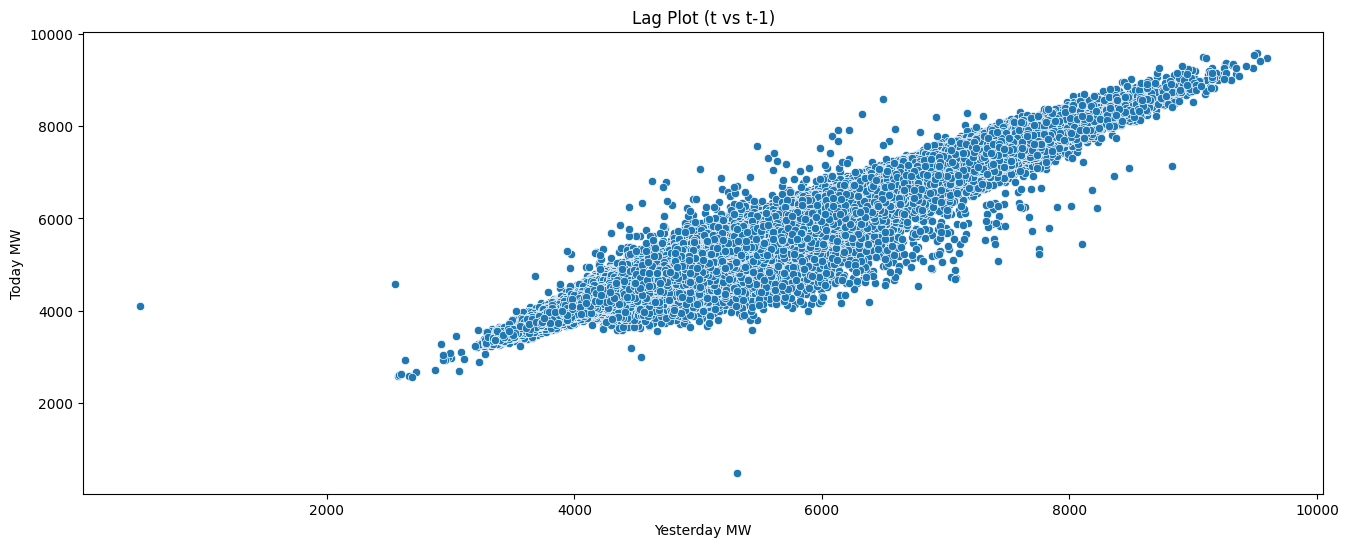

In [9]:
# Remove duplicate indices (keep first occurrence)
df = df[~df.index.duplicated(keep='first')]

plt.figure(figsize=(16, 6))
sns.scatterplot(x=df['PJMW_MW'].shift(1), y=df['PJMW_MW'])
plt.title('Lag Plot (t vs t-1)')
plt.xlabel('Yesterday MW')
plt.ylabel('Today MW')
plt.show()


The data points form a tight diagonal band from bottom-left to top-right.

This indicates a strong positive autocorrelation between yesterday's and today's energy consumption.

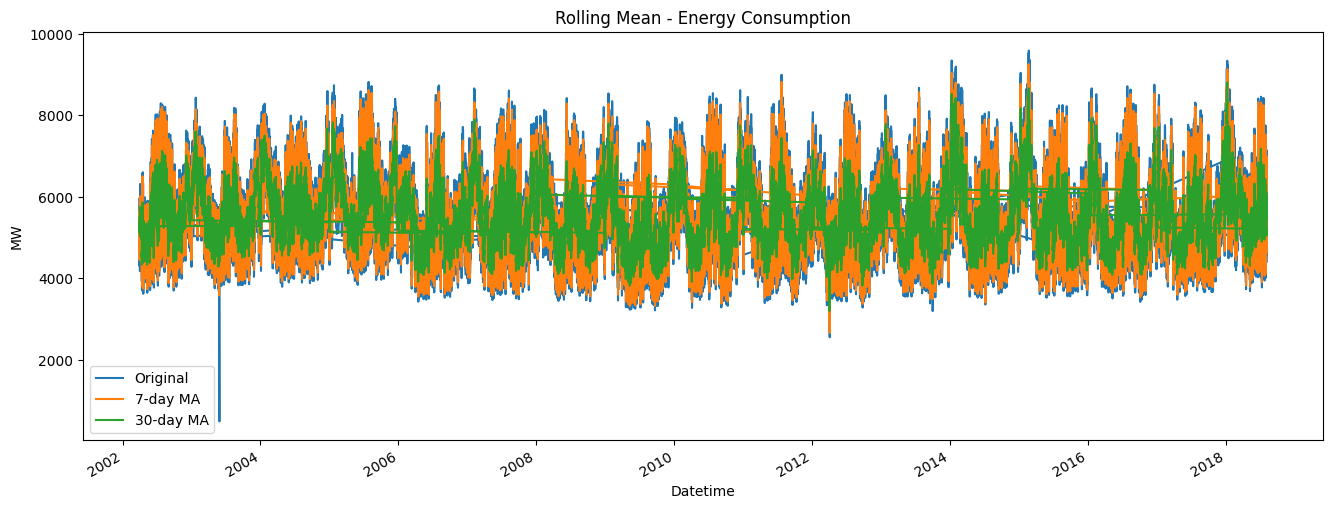

In [10]:
plt.figure(figsize=(16, 6))
df['PJMW_MW'].plot(label='Original')
df['PJMW_MW'].rolling(window=7).mean().plot(label='7-day MA')
df['PJMW_MW'].rolling(window=30).mean().plot(label='30-day MA')
plt.title('Rolling Mean - Energy Consumption')
plt.ylabel('MW')
plt.legend()
plt.show()


This plot shows a strongly seasonal and moderately stable time series, with weekly cycles and short-term noise. This justifies the use of models like SARIMA with seasonal components (7-day)

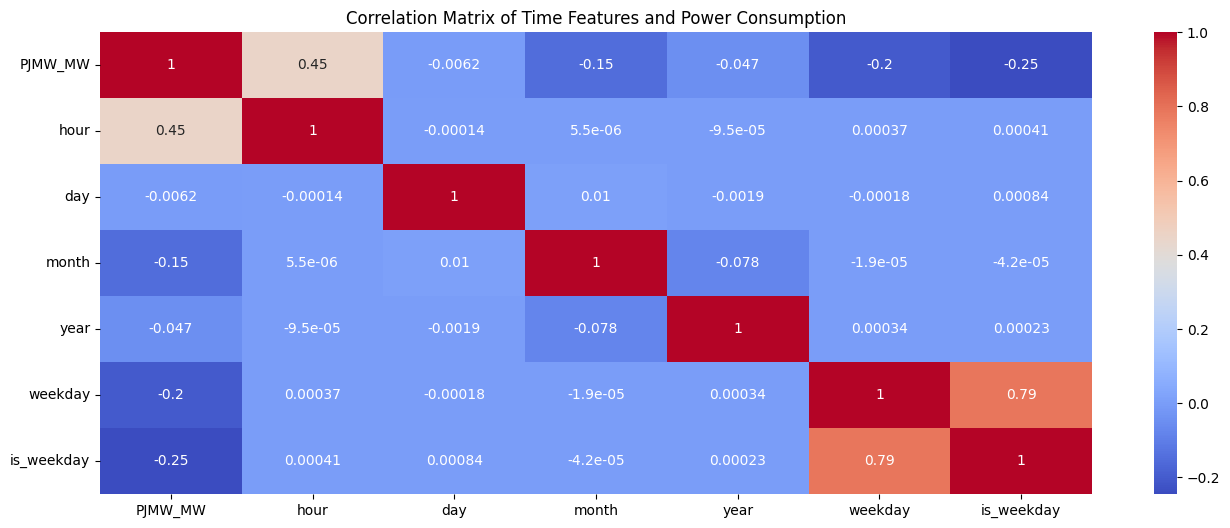

In [11]:
# Correlation Heatmap
# Displays relationships between time-based features and power usage
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='coolwarm')
plt.title("Correlation Matrix of Time Features and Power Consumption")
plt.show()

From the above correlation ,

we found that there is no multi-collinearity in the dataset .

# **Model Development and Forecasting**

# **SARIMAX**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

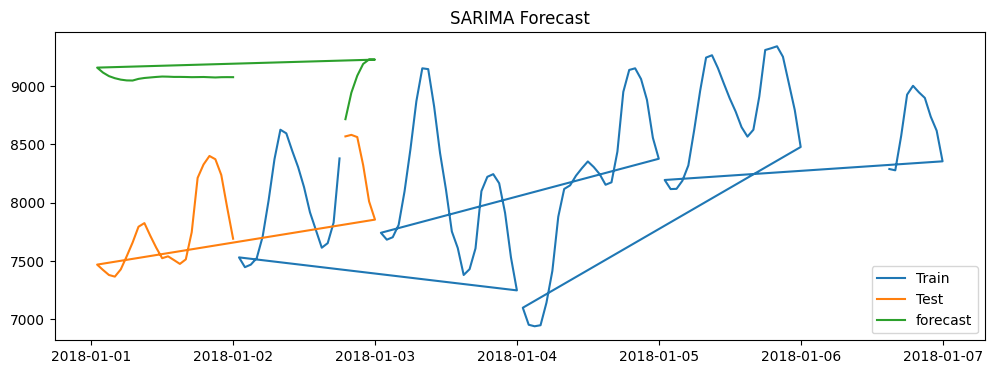

RMSE: 1294.75


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

#split train-test set
train=df['PJMW_MW'].iloc[:-30] #select all the rows except last 30
test=df['PJMW_MW'].iloc[-30:]  #select last 30 rows

#train & fit SARIMA model
model=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,7))
model_fit=model.fit(disp=False)

#forecast
forecast=model_fit.forecast(steps=30)
forecast.index=test.index

#plot
plt.figure(figsize=(12,4))
plt.plot(train[-100:],label="Train")
plt.plot(test,label="Test")
plt.plot(forecast,label="forecast")
plt.title("SARIMA Forecast")
plt.legend()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(test,forecast))
print(f'RMSE: {rmse:.2f}')


# **LSTM**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 76s 16ms/step - loss: 0.0087
Epoch 2/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - loss: 3.3727e-04
Epoch 3/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - loss: 2.7313e-04
Epoch 4/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 2.4505e-04
Epoch 5/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 70s 16ms/step - loss: 2.3516e-04
Epoch 6/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 87s 17ms/step - loss: 2.3666e-04
Epoch 7/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - loss: 2.2326e-04
Epoch 8/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 89s 18ms/step - loss: 2.1880e-04
Epoch 9/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 76s 17ms/step - loss: 2.1239e-04
Epoch 10/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 74s 17ms/step - loss: 2.1040e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


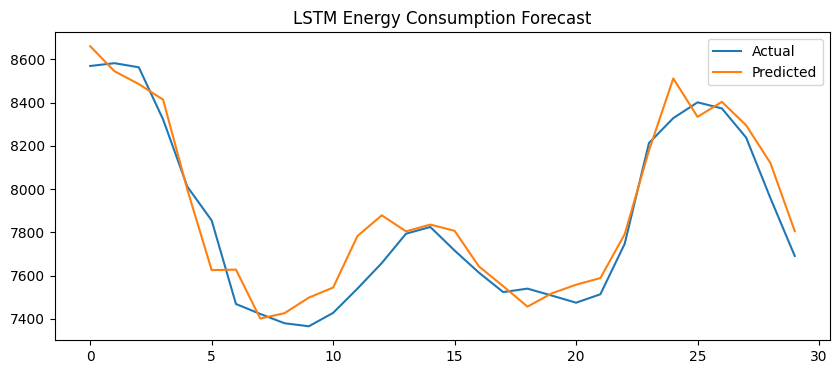

LSTM RMSE: 109.32


In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import joblib


# Use only the target column (assuming 'PJMW_MW')
target = df[['PJMW_MW']]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(target)

# Sequence builder
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Sequence length
seq_len = 30
X, y = create_sequences(scaled_data, seq_len)

# Split into train and test (last 30 points as test)
X_train, y_train = X[:-30], y[:-30]
X_test, y_test = X[-30:], y[-30:]

# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], seq_len, 1))
X_test = X_test.reshape((X_test.shape[0], seq_len, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, verbose=1)

# Forecast
y_pred = model.predict(X_test)

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM Energy Consumption Forecast')
plt.legend()
plt.show()

# Calculate RMSE for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'LSTM RMSE: {lstm_rmse:.2f}')

# Save LSTM model
model.save('lstm_model.h5')


# **XGBOOST**

XGBoost RMSE: 1294.75


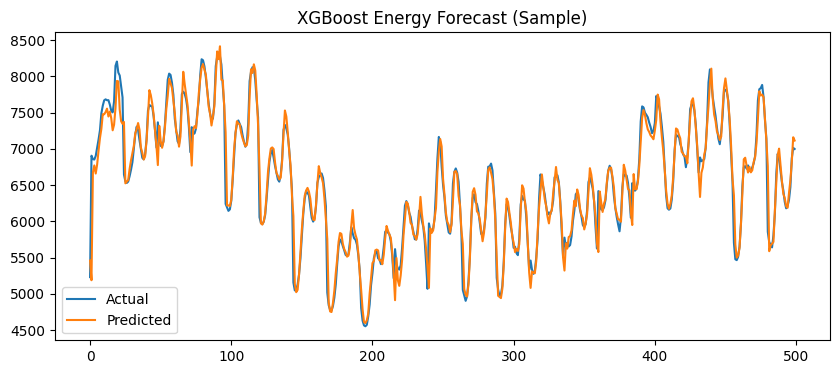

In [14]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Use only the target column
target = df[['PJMW_MW']].copy()

# Create lag features
for lag in range(1, 25):  # using 24 previous hours
    target[f'lag_{lag}'] = target['PJMW_MW'].shift(lag)

# Drop rows with NaN values due to lagging
target.dropna(inplace=True)

# Train-test split
train = target[target.index.year < 2017]
test = target[target.index.year == 2017]

X_train = train.drop('PJMW_MW', axis=1)
y_train = train['PJMW_MW']
X_test = test.drop('PJMW_MW', axis=1)
y_test = test['PJMW_MW']

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'XGBoost RMSE: {rmse:.2f}')

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.title('XGBoost Energy Forecast (Sample)')
plt.legend()
plt.show()


# **Prophet**

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkzwxe1yf/sinv_v5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkzwxe1yf/szm_6alt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90745', 'data', 'file=/tmp/tmpkzwxe1yf/sinv_v5d.json', 'init=/tmp/tmpkzwxe1yf/szm_6alt.json', 'output', 'file=/tmp/tmpkzwxe1yf/prophet_modelx8zamhaa/prophet_model-20250706093906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:39:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


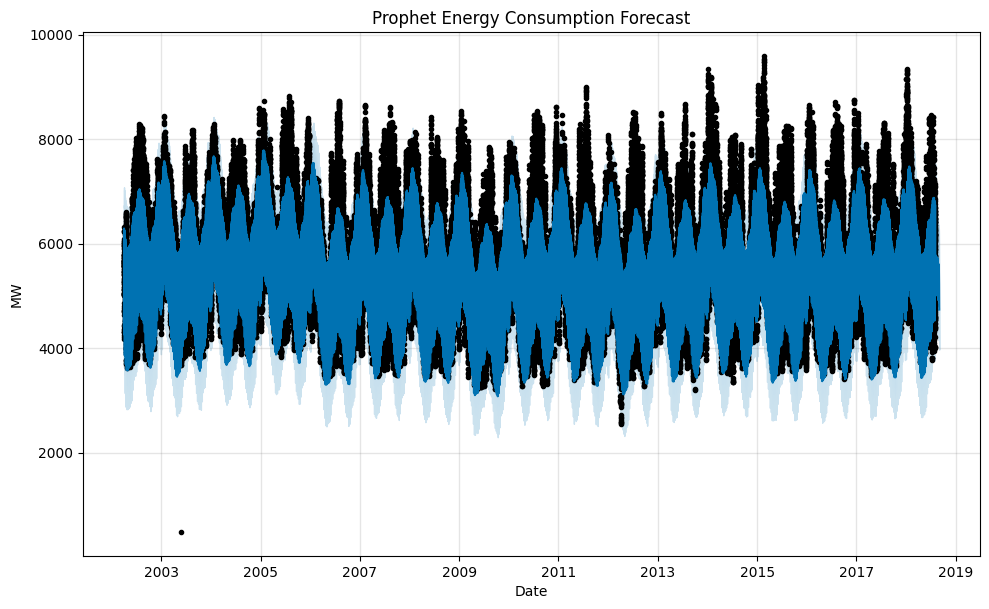

Prophet RMSE: 2444.35


In [15]:
# Prophet Forecasting Model
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Prepare data
prophet_df = df[['PJMW_MW']].copy()
prophet_df['ds'] = df.index
prophet_df['y'] = prophet_df['PJMW_MW']
prophet_df = prophet_df[['ds', 'y']]

# Split into train and test (last 30 days as test)
train_prophet = prophet_df.iloc[:-30]
test_prophet = prophet_df.iloc[-30:]

# Fit model
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(train_prophet)

# Create future dataframe
future = model_prophet.make_future_dataframe(periods=30, freq='D')
forecast = model_prophet.predict(future)

# Plot forecast
model_prophet.plot(forecast)
plt.title("Prophet Energy Consumption Forecast")
plt.xlabel("Date")
plt.ylabel("MW")
plt.show()

# Evaluate
y_true = test_prophet['y'].values
y_pred = forecast['yhat'].iloc[-30:].values
prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Prophet RMSE: {prophet_rmse:.2f}")


# **Arima**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

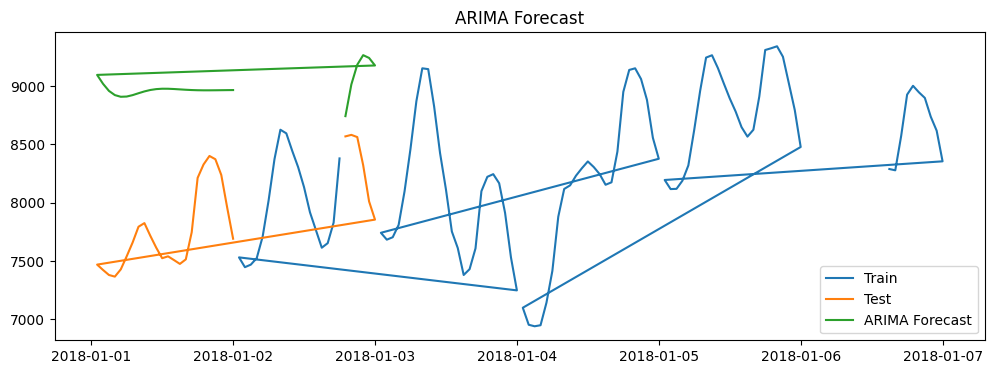

ARIMA RMSE: 1204.71


In [17]:
# ARIMA Forecasting Model (non-seasonal)
from statsmodels.tsa.arima.model import ARIMA

# Train-test split
train = df['PJMW_MW'].iloc[:-30]
test = df['PJMW_MW'].iloc[-30:]

# Fit ARIMA model (non-seasonal)
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=30)

# Plot
plt.figure(figsize=(12,4))
plt.plot(train[-100:], label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

# RMSE
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f"ARIMA RMSE: {arima_rmse:.2f}")

# Save ARIMA model
# joblib.dump(arima_fit, 'arima_model.pkl')

# **Random Forest Regressor**

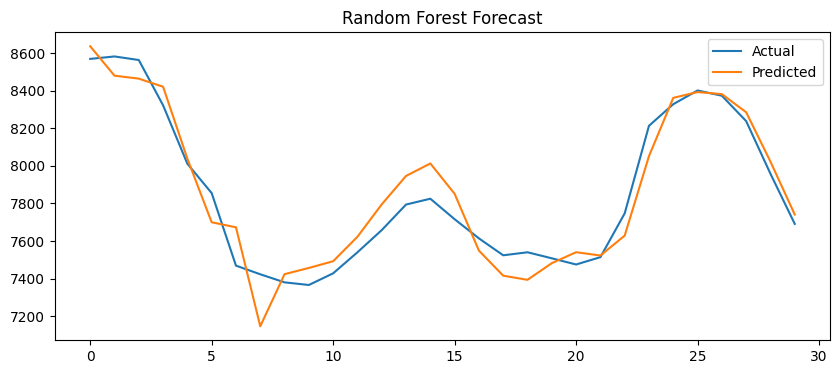

Random Forest RMSE: 113.54


In [18]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create lag features for RF
target = df[['PJMW_MW']].copy()
for lag in range(1, 25):
    target[f'lag_{lag}'] = target['PJMW_MW'].shift(lag)
target.dropna(inplace=True)

# Split into train and test
train_rf = target.iloc[:-30]
test_rf = target.iloc[-30:]

X_train_rf = train_rf.drop('PJMW_MW', axis=1)
y_train_rf = train_rf['PJMW_MW']
X_test_rf = test_rf.drop('PJMW_MW', axis=1)
y_test_rf = test_rf['PJMW_MW']

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predict
rf_pred = rf_model.predict(X_test_rf)

# Plot
plt.figure(figsize=(10,4))
plt.plot(y_test_rf.values, label='Actual')
plt.plot(rf_pred, label='Predicted')
plt.title('Random Forest Forecast')
plt.legend()
plt.show()

# RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, rf_pred))
print(f"Random Forest RMSE: {rf_rmse:.2f}")



**Comparing all the models together**

In [19]:
# Compare All 6 Models
# =====================

print("\nModel Comparison (RMSE):")
print(f"SARIMA RMSE: {rmse:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"Prophet RMSE: {prophet_rmse:.2f}")
print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")


Model Comparison (RMSE):
SARIMA RMSE: 1294.75
LSTM RMSE: 109.32
XGBoost RMSE: 129.27
Prophet RMSE: 2444.35
ARIMA RMSE: 1204.71
Random Forest RMSE: 113.54


# **Interpretation:**

**LSTM** performed the best — indicating it effectively captures complex temporal dependencies.

**XGBoost** performed reasonably well but likely needs additional features (e.g., time-of-day, season).

**SARIMAX** underperformed — it may need better parameter tuning or wasn't well-suited to the hourly data’s complexity.

**Prophet** performed decently for capturing weekly seasonality, but its forecasts smoothed out short-term spikes.

**ARIMA** provided a simple baseline but struggled with capturing seasonal patterns and variability.

**Random Forest** gave competitive results when lag features were well-engineered, but still lacked forecasting strength in highly dynamic sequences.

In [20]:
pip install streamlit

# **Deploymment**

In [21]:
# App file

code="""
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Title
st.title("Energy Consumption Forecasting App - LSTM Model")

# File uploader
uploaded_file = st.file_uploader("Upload your cleaned time series CSV file", type=["csv"])

if uploaded_file:
    df = pd.read_csv(uploaded_file, parse_dates=['weekend_date'])
    df.set_index('weekend_date', inplace=True)
    st.success("Data uploaded and parsed successfully.")
    st.line_chart(df['PJMW_MW'])

    steps = st.slider("Select forecast horizon (days):", min_value=7, max_value=90, value=30)

    if st.button("Run LSTM Forecast"):
        st.subheader("Forecast using LSTM Model")

        # Load the LSTM model
        model = load_model("lstm_model.h5 ")

        # Normalize data for LSTM input
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(df[['PJMW_MW']])

        # Prepare data with lookback window of 30
        lookback = 30
        input_seq = data_scaled[-lookback:].reshape(1, lookback, 1)

        predictions = []
        for _ in range(steps):
            pred = model.predict(input_seq)[0][0]
            predictions.append(pred)
            input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

        # Inverse scale the predictions
        predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

        # Create future date range
        future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=steps)
        result = pd.DataFrame({"Date": future_dates, "Predicted": predicted_values})

        # Display forecast
        st.line_chart(result.set_index("Date"))
        st.success("Forecast complete using LSTM model.") """


with open('app.py','w') as f:
  f.write(code)


